In [1]:
%load_ext cython
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# Loading and decoding porcelain output

* `b%d` => back_ref of %d offset in the initial unknown window
* `c%c` => Resolved char

Build an `chars` array with `int` representing the position in intial unknown window and string for resolved char

In [2]:
!make -j4
!ls -la ~/data/frag_1_O9.fastq.gz
!rm /tmp/backrefs
!./gzip  -c -s 1048576 ~/data/frag_1_O9.fastq.gz 2>/dev/null 1>/tmp/backrefs

-rw-r--r-- 1 piezo users 72471859 29 avril 18:14 /home/piezo/data/frag_1_O9.fastq.gz


In [3]:
chars = []
wsize = 1<<15
for l in open('/tmp/backrefs'):
    if l[0] == 'b':
        chars.append(wsize - int(l[1:-1]))
    elif l[0] == 'c':
        c = l[1:-1]
        if c == '\\n':
            chars.append('\n')
        else:
            chars.append(c)
    else:
        print('bad output line %r' % l)
        
stream_length = len(chars)
stream_length

35553056

# Syncing to decompressed file

First find sequences at the end of decoded stream:

In [4]:
seqs = []
seq = []
seq_start = None
inseq = False
start_pos = stream_length - (15<<10)
for i, c in enumerate(chars[start_pos:]):
    if type(c) is int or c not in 'ATGCNatgcn':
        if inseq:
            if len(seq) > 30:
                seqs.append((seq_start, ''.join(seq)))
            seq_start = None
            seq = []
        inseq = False
    else:
        if not inseq:
            seq_start = i + start_pos
        inseq = True
        seq.append(c)

In [5]:
# Find the sequence in the decoded file :
import gzip
from collections import Counter

f = gzip.open('/home/piezo/data/frag_1.fastq.gz', mode='rt')
content = f.read()


candidates_pos = Counter()
for pos, seq in seqs:
    res = 0
    while True:
        res = content.find(seq, res)
        if res == -1:
            break
        else:
            candidates_pos[res - pos]+=1
        res +=1
        
delta = candidates_pos.most_common(1)[0][0]
delta

3471656

In [6]:
# Check first 1MB
context = content[delta - wsize:delta]
for i,c in enumerate(chars[:1<<20]):
    content_c = content[delta+i]
    assert (type(c) is int and context[c] == content_c) or c == content_c

In [7]:
import re
context_types = np.zeros(wsize, dtype=np.uint8)
context_types_labels = ['sequence header', 'sequence', 'quality header', 'quality']

for m in re.finditer(r"\n@.*?\n", context):
    context_types[m.start():m.end()] = 1

for m in re.finditer(r"\n\+\n", context):
    context_types[m.start():m.end()] = 3
    
    
first_delim = np.where(context_types>0)[0][0]
if context_types[first_delim]==1:
    context_types[:first_delim] = 4
else:
    context_types[:first_delim] = context_types[first_delim]-1
    
prev = context_types[first_delim]
for i, ct in enumerate(context_types[first_delim+1:], first_delim+1):
    if ct == 0:
        context_types[i] = (prev%4)+1
    else:
        prev = ct
        
print(''.join("\x1B[3%dm%s\x1B[0m" % (ct, c) if c != '\n'
              else "\x1B[31m\\n\n\x1B[0m" % ct
              for c, ct in zip(context[:500], context_types)))

context_types -= 1

@CEBEECFBBEBFB=B;@3===4>\n
@SRR081522.572158/1\n
GGGCGGAAGCTCGCGCACCCCCCGGATCGGCGGCTCTTCCGCCCGCGCCGCCCGAGCGAGCAGCTGGGGGCAGCGGTTCCCCGCGCCCCCGTCTACCGGGC\n
+\n
#####################################################################################################\n
@SRR081522.572183/1\n
ATCCGCATCTCGGGCGGCGGCCGCTGCAACTTCACCAACCTCGGGATCGCGCCCGAGCGGTTCCTGTCACGCAATCCGCGCTTCGCGCTGTCGGCGCTGAA\n
+\n
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIHIIIGIIHHHHIDIIIIIHHHHEFFIIEIDCIIFHHCGDG@DD@A<BBB@BBBE@CEA?A6>@???##\n
@SRR081522.572187/1\n
GCT


In [8]:
last_seen = np.zeros(wsize, dtype=np.uint32)
# backref range [0, wsize[ => wsize encode resolved char
backrefs = np.ones(len(chars), dtype=np.uint16)*wsize
for i,bref in enumerate(chars):
    if(type(bref) is int):
        assert(bref != wsize)
        backrefs[i] = bref
        last_seen[bref] = i

In [9]:
never_referenced = last_seen == 0
always_referenced = last_seen >= stream_length - wsize
mask_referenced = ~never_referenced & ~always_referenced
postwin_referenced = last_seen >= (1<<15)

arr_context = np.array(list(context))

print('Number of character in unknown context,')
for ct, lbl in enumerate(context_types_labels):
    m = context_types == ct
    print()
    print('\tand in %s,' % lbl)
    print('\t\ttotal:\t\t\t\t', np.sum(m))
    print('\t\tnever referenced:\t\t', np.sum(m & never_referenced))
    print('\t\treferened not until the end:\t', np.sum(m & mask_referenced))
    print('\t\treferened after 32K:\t\t', np.sum(m & postwin_referenced))
    print('\t\treferened until the end:\t', np.sum(m & always_referenced),
         repr(''.join(arr_context[np.where(m & always_referenced)[0]])))
    
del arr_context

Number of character in unknown context,

	and in sequence header,
		total:				 3126
		never referenced:		 2729
		referened not until the end:	 383
		referened after 32K:		 154
		referened until the end:	 14 '\n@SRR081522.1\n'

	and in sequence,
		total:				 14665
		never referenced:		 9898
		referened not until the end:	 4767
		referened after 32K:		 2538
		referened until the end:	 0 ''

	and in quality header,
		total:				 435
		never referenced:		 315
		referened not until the end:	 117
		referened after 32K:		 69
		referened until the end:	 3 '\n+\n'

	and in quality,
		total:				 14542
		never referenced:		 11567
		referened not until the end:	 2975
		referened after 32K:		 1346
		referened until the end:	 0 ''


In [10]:
sorter = np.argsort(np.bincount(context_types[last_seen != wsize]))
context_types_labels = np.array(context_types_labels)[sorter]
context_types = np.argsort(sorter)[context_types]

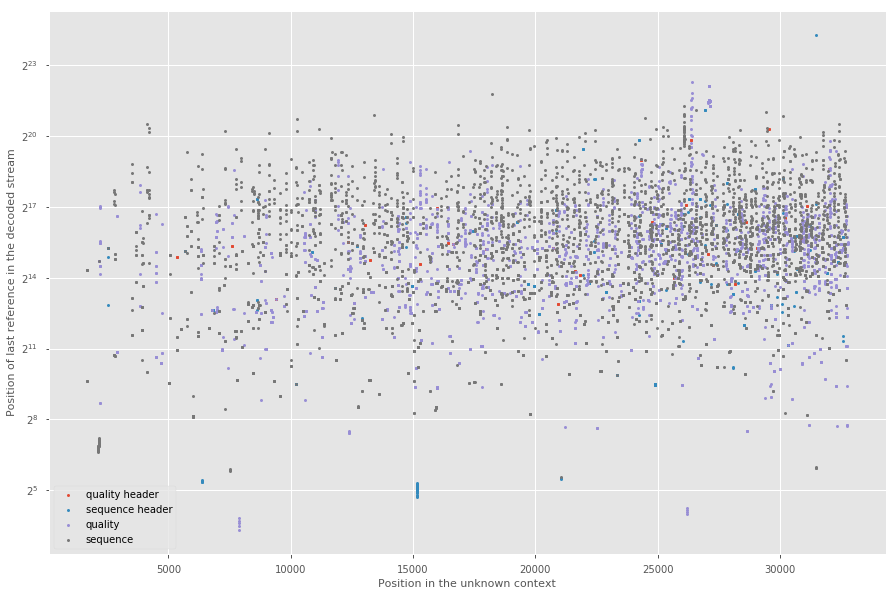

In [11]:
plt.figure(figsize=(15,10))

xaxis = np.arange(wsize)
for ct, lbl in enumerate(context_types_labels):
    m = mask_referenced & (context_types==ct)
    plt.plot(xaxis[m], last_seen[m], 'o', markeredgecolor='none', markersize=3, label=lbl);
plt.yscale('log', basey=2)
plt.xlabel('Position in the unknown context')
plt.ylabel('Position of last reference in the decoded stream')
plt.legend(loc=3);

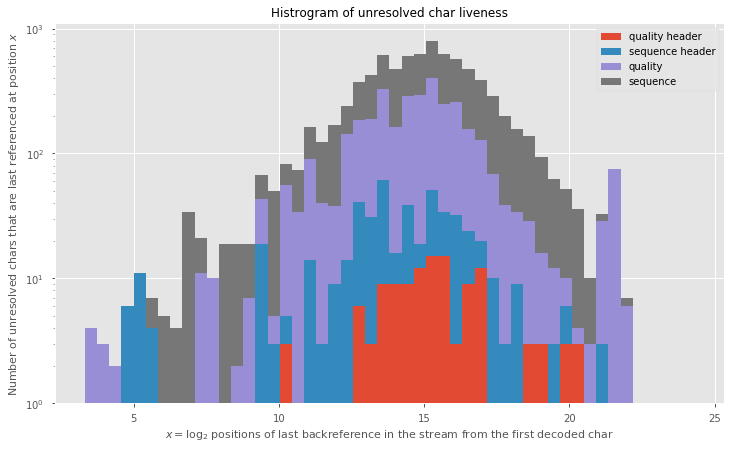

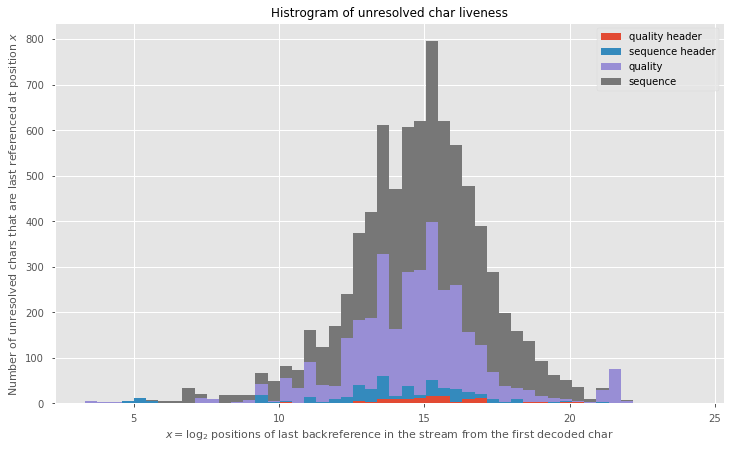

In [12]:
for log in [True, False]:
    plt.figure(figsize=(12,7))
    plt.hist([np.log2(last_seen[mask_referenced & (context_types==i)]) for i in range(4)],
             label=context_types_labels,
             stacked=True, bins=50, log=log);
    plt.title('Histrogram of unresolved char liveness')
    plt.xlabel('$x=\log_2$ positions of last backreference in the stream from the first decoded char')
    plt.ylabel('Number of unresolved chars that are last referenced at position $x$');
    plt.legend()

In [13]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def type_mask_backrefs(np.ndarray[np.uint16_t] backrefs, set s, wsize=1<<15):
    cdef np.ndarray[np.uint8_t] mask = np.zeros(len(backrefs), dtype=np.uint8)
    cdef int br, i
    for i, br in enumerate(backrefs):
        if br in s and br!=wsize:
            mask[i] = 1
    return mask.view(dtype=np.bool)

In [14]:
def count_backrefs_sliding_window(mask, decimate_power=5, wsize=1<<15):
    # Count the number of backref per 32K sliding windows :

    # First decimate is_backref by a factor of 32
    # ie we count the number of backrefs for each 64char non overlapping window
    unresolved_inwin = mask.astype(np.uint16)
    decimate_factor = 1
    for i in range(decimate_power):
        unresolved_inwin = unresolved_inwin[:len(unresolved_inwin) & ~1]
        unresolved_inwin = unresolved_inwin[1::2] + unresolved_inwin[0::2]
        decimate_factor *= 2

    # count bacrefs in sliding window of 32k:
    unresolved_inwin = np.convolve(unresolved_inwin,np.ones(wsize//decimate_factor,dtype=np.uint16), 'valid')
    unresolved_inwin_xaxis = np.arange(len(unresolved_inwin)) * decimate_factor 
    unresolved_inwin_xaxis += 1 # Window overlapping the first byte is indexed at one
    
    return unresolved_inwin_xaxis, unresolved_inwin

# Count the number of live reference to *unique positions* in the initial window, per 32K sliding window:
def count_unique_backrefs_sliding_window(backrefs, mask, n=2048, wsize=1<<15):
    at = 2**np.linspace(0, np.log2(len(backrefs)-wsize), n)
    at = np.unique(np.ceil(at).astype(np.uint32))
    at = at[at < len(backrefs)-wsize]
    unique_brefs_counts = np.zeros(len(at), dtype=np.uint16)
    for i, pos in enumerate(at-1):
        sl = slice(pos, pos+wsize)
        unique_brefs_counts[i] = len(np.unique(backrefs[sl][mask[sl]]))
    return at, unique_brefs_counts

In [15]:
stack_backrefs_count = []
stack_unique_backrefs_count = []

for i in range(4):
    s = set(np.where((context_types==i) & ~never_referenced) [0])
    m = type_mask_backrefs(backrefs, s)
    brefs_counts_xaxis, brefs_counts = count_backrefs_sliding_window(m)
    unique_brefs_counts_xaxis, unique_brefs_counts = count_unique_backrefs_sliding_window(backrefs, m)
    del s, m
    
#     if stack_backrefs_count:
#         brefs_counts += stack_backrefs_count[-1]
#         unique_brefs_counts += stack_unique_backrefs_count[-1]
        
    stack_backrefs_count.append(brefs_counts)
    stack_unique_backrefs_count.append(unique_brefs_counts)
    del brefs_counts, unique_brefs_counts

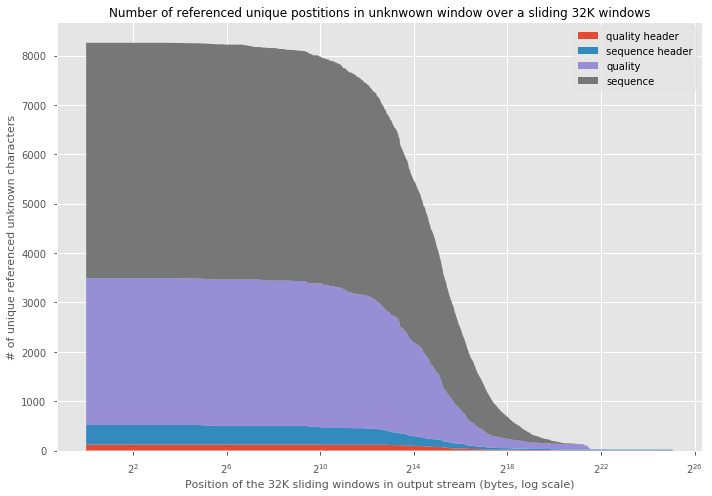

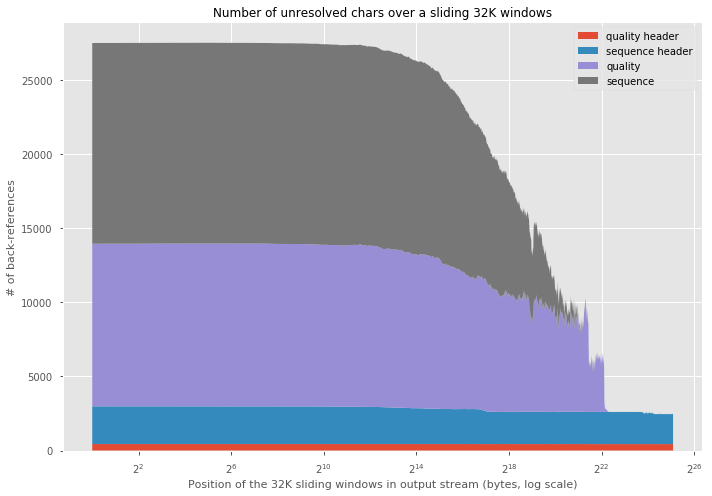

In [16]:
def plot_unresolved(log=True, minx=0, figsize=(10,7), title='',
                   xlabel='Position of the 32K sliding windows in output stream (bytes, log scale)'):
    if title:
        title='\n'+title
    
    fig1 = plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_title('Number of referenced unique postitions in unknwown window over a sliding 32K windows'+title);
    if(log):
        ax.set_xscale('log', basex=2)
        
    startx = np.searchsorted(unique_brefs_counts_xaxis, minx)
    ax.stackplot(unique_brefs_counts_xaxis[startx:], 
                  [y[startx:] for y in stack_unique_backrefs_count],
                  linestyle='-', baseline='zero', linewidth=1, labels=context_types_labels)
    ax.set_ylabel('# of unique referenced unknown characters');
    ax.set_xlabel(xlabel)
    ax.legend();
    fig1.tight_layout()

    
    fig2 = plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_title('Number of unresolved chars over a sliding 32K windows');
    if(log):
        ax.set_xscale('log', basex=2)
    
    startx = np.searchsorted(brefs_counts_xaxis, minx)
    ax.stackplot(brefs_counts_xaxis[startx:], 
                  [y[startx:] for y in stack_backrefs_count],
                  linestyle='-', baseline='zero', linewidth=1, labels=context_types_labels)

    ax.set_ylabel('# of back-references');
    ax.set_xlabel(xlabel)
    ax.legend();

    fig = plt.gcf()
    fig2.tight_layout()
    return fig1, fig2
    
fig1, fig2 = plot_unresolved();

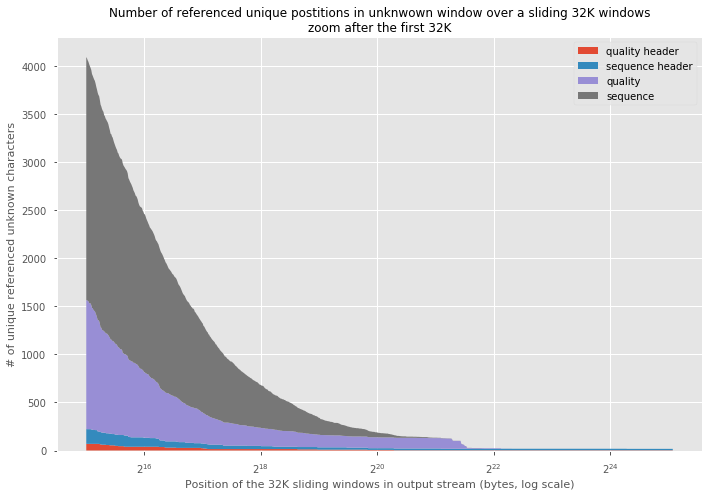

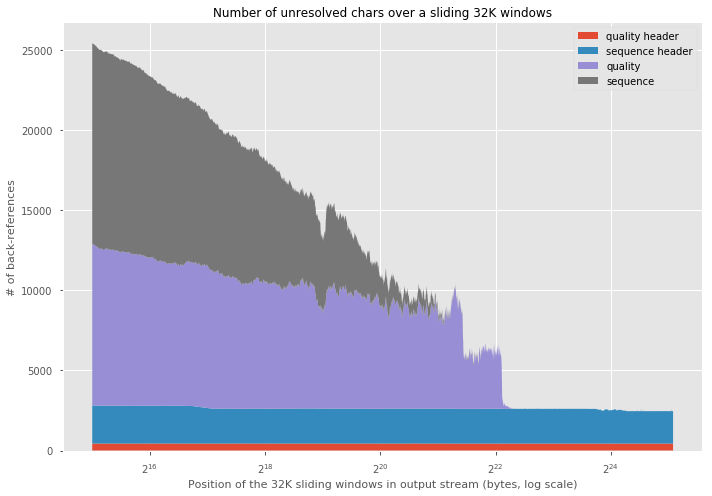

In [17]:
fig1, fig2 = plot_unresolved(minx=1<<15, title='zoom after the first 32K')

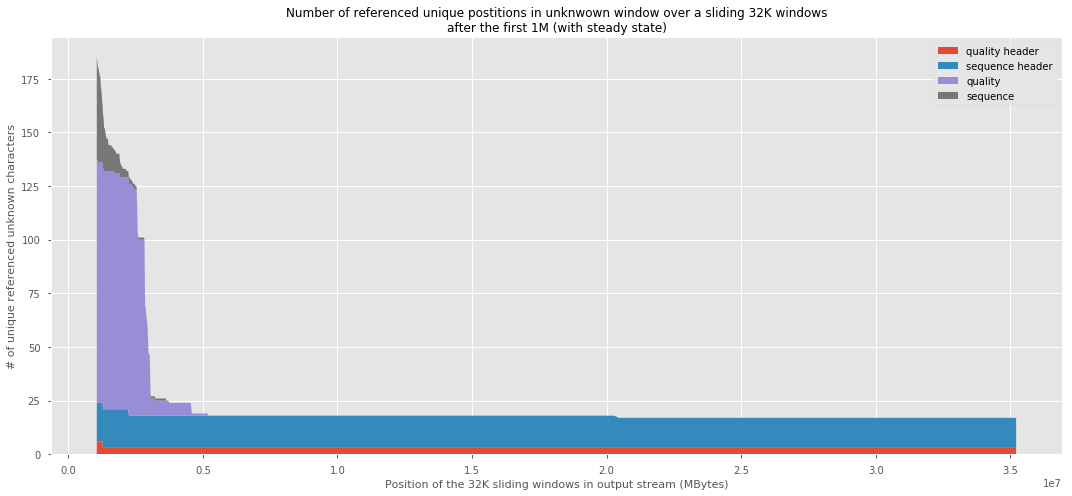

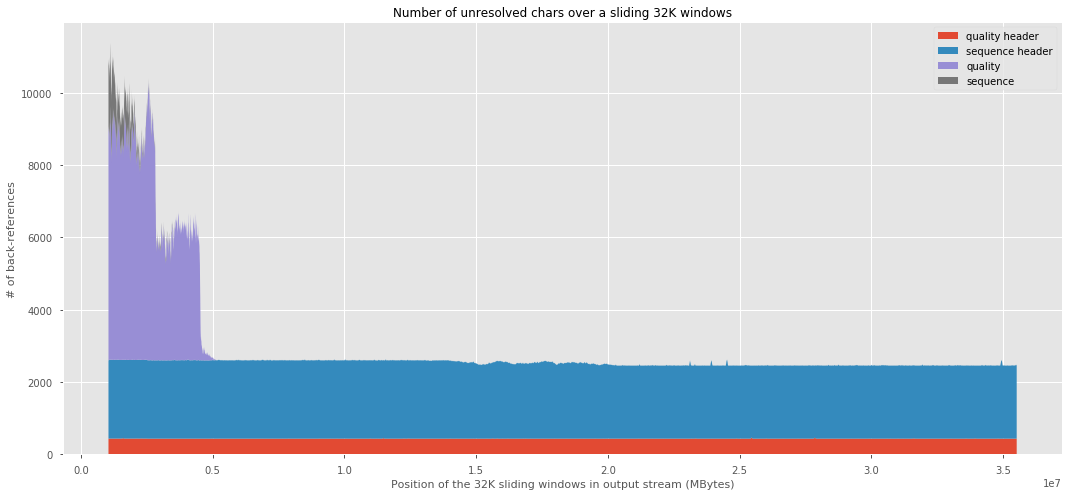

In [18]:
plot_unresolved(minx=1<<20, log=False, figsize=(15,7), 
                title='after the first 1M (with steady state)',
                xlabel='Position of the 32K sliding windows in output stream (MBytes)');